# 1週間分のルールを作成するためのprogram

In [163]:
#加工前データ
import xlrd
import pprint
import openpyxl
import numpy as np
from datetime import datetime as dt
import pandas as pd
from sklearn import preprocessing
import copy

In [214]:
bed_data_filename = 'bed_data.csv'
before_csv = 'osaka_data_before.csv'
data_filename = 'osaka_data_before.xlsx'
save_filename = 'before_1week_ver2.xlsx'
data_sheet = 'Sheet1'

In [132]:
#開始日と終了日を参照する
df = pd.read_csv('./data/'+bed_data_filename, encoding='shift-jis', index_col=0, parse_dates=['日付'])
start_day = df.index[0]
end_day = df.index[-1]
start_day, end_day

(Timestamp('2020-07-30 00:00:00'), Timestamp('2021-09-18 00:00:00'))

In [233]:
test_start = dt(2020,10,1,0)
#test_end = dt(2021,1,11,0)
day_num = (end_day-start_day).days

#diff
total_data_num = day_num+1 -1 
test_data_num = (end_day-test_start).days+1 -1

teach_data_num = total_data_num-test_data_num

#メンバシップ関数の数
func_num = 3
#入力変数
x_dimension = 6
#学習する変数の数
total_dimension = func_num**x_dimension
#学習回数
max_iter = 100
omega_iter = 100
#学習係数
l_rate = 0.5

In [134]:
#csvからexcelへの変換
# csvファイルを読み込む
before_csv = pd.read_csv('./data/'+before_csv, encoding='shift-jis')

# エクセルファイルに書き込む
writer = pd.ExcelWriter('./data/'+data_filename)
before_csv.to_excel(writer,data_sheet,index=False) # header=False

#　保存
writer.save()

In [135]:
#データ関連関数
def get_value_list(t_2d):
    return([[cell.value for cell in row] for row in t_2d])

def get_list_2d(sheet, start_row, end_row, start_col, end_col):
    return get_value_list(sheet.iter_rows(min_row=start_row,
                                          max_row=end_row,
                                          min_col=start_col,
                                         max_col=end_col))

def write_list_2d(sheet, l_2d, start_row, start_col):
    for y, row in enumerate(l_2d):
        for x, cell in enumerate(row):
            sheet.cell(row=start_row + y,
                       column=start_col + x,
                       value=l_2d[y][x])

In [136]:
#μやωからyを計算
def cal_y(m, total_m, y, w, omega):
    temp = 0
    for (i, j, l) in zip(m, w, omega):
        temp += i * j * l
    y[1] = temp/total_m

In [137]:
#データを扱いやすく変形
def set_data(y, Y, data, b, c, omega): 
    for i in range(total_data_num):
        y.append([(Y[i][0]-np.min(Y))/(np.max(Y)-np.min(Y)),(np.mean(Y)-np.min(Y))/(np.max(Y)-np.min(Y))])
        
    for i in range(total_dimension):
        omega[i] = (i+1)/total_dimension

In [138]:
#メンバーシップ関数
def fun(c, b, fun_data, data):    
    for i in range(total_data_num):
        for j in range(x_dimension):
            for k in range(func_num):
                #print(i,j,data[i][j])
                if data[i][j] < c[k]-b[k]:
                    fun_data[i][k][j] = 0
                elif data[i][j] > c[k]+b[k]:
                    fun_data[i][k][j] = 0
                elif data[i][j] >= c[k]-b[k] and data[i][j] <= c[k]:
                    fun_data[i][k][j] = 1-abs(c[k]-data[i][j])*(1/b[k])
                elif data[i][j] > c[k] and data[i][j] <= c[k]+b[k]:
                    fun_data[i][k][j] = 1-abs(c[k]-data[i][j])*(1/b[k])

In [139]:
#データに関数を適用する関数
def rule(m, total_m, fun_data, data, c, b, w):
    fun(c, b, fun_data, data)
    
    for d_num in range(total_data_num):
        for j in range(x_dimension):
            times = 0
            R = func_num**(x_dimension-1-j)
            for p in range(R):
                for i in range(func_num):
                    r = func_num**j
                    for k in range(r):
                        m[d_num][times] *= fun_data[d_num][i][j]
                        times+=1
                        
    #学習用とテスト用のμの総和
    for j in range(total_data_num):
        for i in range(total_dimension):
            total_m[j] += m[j][i] * w[i]

"""
for i in range(omega_iter):    
    for j in range(teach_data_num):
        for dim in range(total_dimension):
            omega[dim] -= l_rate * (-y[j][0]+y[j][1]) * m[j][dim] / total_m[j]
            w[dim] = w[dim] - l_rate *  (-y[j][0]+y[j][1]) * m[j][dim] * (omega[dim]-y[j][1]) / total_m[j]"""
            '''if temp_w < 0:
                w[dim] = 0
            else:
                w[dim] = temp_w'''

In [169]:
#最急降下法 改良
def gradient_descent(total_m, m, y, w, omega, mse):
    
    #累計学習回数 ※データ数ではなく学習した週の数
    for week in range(int(total_data_num/7)):
        #学習によって書き換えが生じてしまため、コピーを作成
        temp_y = copy.deepcopy(y)
        temp_tm = copy.deepcopy(total_m)
        temp_m = copy.deepcopy(m)
        temp_w = copy.deepcopy(w)
        temp_omega = copy.deepcopy(omega)
        
        #後件部の学習
        for i in range(omega_iter):
            for j in range(7):
                for dim in range(total_dimension):
                    temp_omega[dim] -= l_rate * (-temp_y[week*7+j][0]+temp_y[week*7+j][1]) * temp_m[week*7+j][dim] / temp_tm[week*7+j]
                    temp_w[dim] = temp_w[dim] - l_rate *  (-temp_y[week*7+j][0]+temp_y[week*7+j][1]) * temp_m[week*7+j][dim] * (temp_omega[dim]-temp_y[week*7+j][1]) / temp_tm[week*7+j]
                temp1 = 0
                temp2 = 0
                for r, W, ome in zip(temp_m[week*7+j], temp_w, temp_omega):
                    temp1 += r * W * ome
                    temp2 += r * W
                temp_tm[week*7+j] = temp2
                temp_y[week*7+j][1] = temp1/temp_tm[week*7+j]
        save_result(temp_y, temp_w, temp_omega, temp_m, temp_tm, week)
    print("後件部学習終了")
    print("重み学習終了")
    
    '''#testデータで
    for i in range(teach_data_num,total_data_num):
        temp = 0
        for l,r in zip(m[i],w):
            temp += l*r
            if r > 0.75:
                temp += l*r
        total_m[i] = temp
        
        #エラー処理
        if total_m[i] == 0:
            print(CV_num,i)

        temp = 0
        for r, W, ome in zip(m[i], w, omega):
            temp += r * W * ome
        y[i][1] = temp/total_m[i]'''

    #MES(y, mse, max_iter, w, omega, 'test')
    #save_result(y, w, omega, m, total_m, 2)

In [141]:
def MES(y, mse, n, w, omega, litera):
    temp = 0
    
    if litera=='teach':
        for i in range(teach_data_num):
            temp += (y[i][1] - y[i][0])**2
        mse = temp/teach_data_num
    else:
        for i in range(teach_data_num,total_data_num):
            temp += (y[i][1] - y[i][0])**2
        mse = temp/test_data_num
    
    wc = openpyxl.load_workbook('./output/osaka/'+save_filename, data_only=True)
    for sheet_name in wc.sheetnames:
        if sheet_name == 'output':
            wc["sq_error"].cell(column=1, row=1+n, value = mse)
            
            wc.save('./output/osaka/'+save_filename) 
        else:
            err_sheet = wc.create_sheet('sq_error')
            err_sheet.cell(column=1, row=1+n, value = mse)
    return 

In [161]:
#excelの保存
def save_result(y, w, omega, m, total_m, week_num):
    
    wc = openpyxl.load_workbook('./output/osaka/'+save_filename, data_only=True)
    
    y_sheet = wc['y']
    if week_num == 0:
        write_list_2d(y_sheet,[['理想値week'+str(week_num),'week'+str(week_num)]], 1, 1)
        write_list_2d(y_sheet,y[:,:1], 2, 1)
        write_list_2d(y_sheet,y[:7,1:], 2, 2)
    else:
        write_list_2d(y_sheet,[['week'+str(week_num)]], 1, 2+week_num)
        write_list_2d(y_sheet,y[week_num*7:(week_num+1)*7,1:], 2+week_num*7, 2+week_num)
    
    
    wc.save('./output/osaka/'+save_filename)
    print("Save complited.week"+str(week_num))
    
    
    '''for sheet_name in wc.sheetnames:
        if sheet_name == 'y':
            omega_sheet = wc["omega"]
            for i in range(total_dimension):
                omega_sheet.cell(column=1, row=i+1, value = omega[i])

            w_sheet = wc["w"]
            for i in range(total_dimension):
                w_sheet.cell(column=1, row=i+1, value = w[i])

            m_sheet = wc["m"]
            for i in range(total_data_num):
                for j in range(total_dimension):
                    m_sheet.cell(column=1+i, row=1+j, value = m[i][j])

            total_m_sheet = wc["total_m"]
            for i in range(total_data_num):
                total_m_sheet.cell(column=1+i, row=1, value = total_m[i])
        else:

            write_list_2d(wc["output"],[['理想値','出力値']], 1, 1)
            write_list_2d(wc["output"],output_list, 2, 1)

            #wc["sq_error"].cell(column=1, row=1, value = mse)

        wc.save('./output/osaka/'+save_filename)
        print("Already exist. Save complited ") ''' 
    return 
        
    '''output_sheet = wc.create_sheet('output')
    write_list_2d(output_sheet,[['理想値','出力値']], 1, 1)
    write_list_2d(output_sheet,output_list, 2, 1)
    #err_sheet = wc.create_sheet('sq_error')
    #err_sheet.cell(column=1, row=1, value = mse)
    
    w_sheet = wc.create_sheet('w')
    for i in range(total_dimension):
        w_sheet.cell(column=1, row=i+1, value = w[i])
        
    w_sheet = wc.create_sheet('omega')
    for i in range(total_dimension):
        w_sheet.cell(column=1, row=i+1, value = omega[i])
    
    wc.save('./output/osaka/'+save_filename)
    print("Save complited ")
    return '''

In [143]:
#excelの保存
def save_fix_result(fix):
    wc = openpyxl.load_workbook('./output/osaka/'+save_filename, data_only=True)
    for sheet_name in wc.sheetnames:
        if sheet_name == 'output':
            fix_sheet = wc["fix"]
            write_list_2d(fix_sheet,[['理想値','出力値']], 1, 1)
            write_list_2d(fix_sheet,fix, 2, 1)
    wc.save('./output/osaka/'+save_filename)
    print("Already exist. Save complited ")  
    return 

In [144]:
#出力yを導出する関数
def make_output(total_m, m, y, fun_data, data, omega, c, b, w, sq_err):
    
    print("学習開始")
    gradient_descent(total_m, m, y, w, omega, sq_err)
    print("学習完了")
    
    return 0

def main():
    before_csv = pd.read_csv('./data/'+before_csv, encoding='shift-jis')
    csv_data = 
    #Excelの指定
    wb = openpyxl.load_workbook('./data/'+data_filename, data_only=True)
    data_sheet = wb['Sheet1']

    '''
    data：データ
    y：病床占有率
    fun_data：関数を通したデータの値
    m：ルールに対する適合度
    total_m：適合度の総和
    omega：ルール後件部
    w：ルールの重み
    mse：平均2乗誤差
    c：関数の中心
    b：関数の幅
    '''
    
    start_row = 2
    data = get_list_2d(data_sheet, start_row, total_data_num+start_row-1, 2, x_dimension+1)
    Y = get_list_2d(data_sheet, start_row, total_data_num+start_row-1, x_dimension+2, x_dimension+2)
    y = []
    fun_data = np.empty((total_data_num, func_num, x_dimension))
    m = np.ones((total_data_num, total_dimension))
    total_m = np.zeros(total_data_num)
    omega = np.zeros(total_dimension)
    w = np.ones(total_dimension)
    mse = np.zeros(max_iter)
    
    #中心と幅の初期値の設定
    c = [0, 0.5, 1] 
    b = [1, 0.5, 1] #変えるべき
    
    #参照問題でここで正規化
    #保存して、読み込みでもいいかも
    mm = preprocessing.MinMaxScaler()
    mm_data = mm.fit_transform(data)
    mm.fit(Y)
    print("正規化完了")
    
    #データのセット
    set_data(y, Y, mm_data, b, c, omega)   
    print("データセット完了")
    rule(m, total_m, fun_data, mm_data, c, b, w)
    
    make_output(total_m, m, y, fun_data, mm_data, omega, c, b, w, mse)
    
    #予測値を%表記に逆標準化
    #結合・逆変換のために型変換
    y_ = np.array(y)
    Y_ = np.array(Y)
    mm_y_ = y_[:, 1].reshape(-1,1)
    mm_y = mm.inverse_transform(mm_y_)
    fix_y = np.append(mm_y, Y_, axis=1)
    #pprint.pprint(fix_y)
    
    save_fix_result(fix_y)
    
if __name__ == '__main__':
    
    main()
    

In [170]:
#csv版の作成途中
csv_data = before_csv.drop(['日付'], axis=1)

#参照問題でここで正規化
#保存して、読み込みでもいいかも
mm = preprocessing.MinMaxScaler()
mm_data = mm.fit_transform(csv_data)
print("正規化完了")

#中心と幅の初期値の設定
c = np.array([0, 0.5, 1])
b = np.array([1, 0.5, 1]) #変えるべき

#データの準備
fun_data = np.empty((total_data_num, func_num, x_dimension))
m = np.ones((total_data_num, total_dimension))
total_m = np.zeros(total_data_num)
omega = [(i+1)/total_dimension for i in range(total_dimension)]
w = np.ones(total_dimension)
mse = np.zeros(max_iter)

y_mean = np.mean(mm_data[:,len(mm_data[0])-1:], axis=0)
y = np.hstack((mm_data[:,len(mm_data[0])-1:], np.full((len(mm_data),1), y_mean)))
mm_data = mm_data[:,:len(mm_data[0])-1]

rule(m, total_m, fun_data, mm_data, c, b, w)
print("データセット完了")

make_output(total_m, m, y, fun_data, mm_data, omega, c, b, w, mse)

正規化完了
データセット完了
学習開始
Save complited.week0
Save complited.week1
Save complited.week2
Save complited.week3
Save complited.week4
Save complited.week5
Save complited.week6
Save complited.week7
Save complited.week8
Save complited.week9
Save complited.week10
Save complited.week11
Save complited.week12
Save complited.week13
Save complited.week14
Save complited.week15
Save complited.week16
Save complited.week17
Save complited.week18
Save complited.week19
Save complited.week20
Save complited.week21
Save complited.week22
Save complited.week23
Save complited.week24
Save complited.week25
Save complited.week26
Save complited.week27
Save complited.week28
Save complited.week29
Save complited.week30
Save complited.week31
Save complited.week32
Save complited.week33
Save complited.week34
Save complited.week35
Save complited.week36
Save complited.week37
Save complited.week38
Save complited.week39
Save complited.week40
Save complited.week41
Save complited.week42
Save complited.week43
Save complited.week44


0

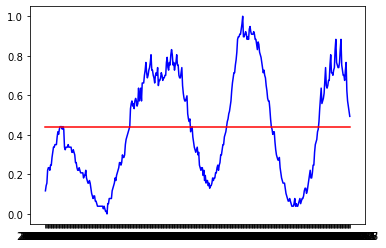

In [174]:
from matplotlib import pyplot as plt

pyplot.figure()
plt.plot(before_csv['日付'], y[:,:1], color='blue')
plt.plot(before_csv['日付'], y[:,1:], color='red')